In [1]:
from pystencils.session import *

# Demo: Assignment collections and simplification


## Assignment collections

The assignment collection class helps to formulate and simplify assignments for numerical kernels. 

An ``AssignmentCollection`` is an ordered collection of assignments, together with an optional ordered collection of subexpressions, that are required to evaluate the main assignments. There are various simplification rules available that operate on ``AssignmentCollection``s.

We start by defining some stencil update rule. Here we also use the *pystencils* ``Field``, note however that the assignment collection module works purely on the *sympy* level.

In [2]:
a,b,c = sp.symbols("a b c")
f = ps.fields("f(2) : [2D]")
g = ps.fields("g(2) : [2D]")

a1 = ps.Assignment(g[0,0](1), (a**2 +b) * f[0,1] + \
                  (a**2 - c) * f[1,0] + \
                  (a**2 - 2*c) * f[-1,0] + \
                  (a**2) * f[0, -1])

a2 = ps.Assignment(g[0,0](0), (c**2 +b) * f[0,1] + \
                  (c**2 - c) * f[1,0] + \
                  (c**2 - 2*c) * f[-1,0] + \
                  (c**2 - a**2) * f[0, -1])


ac = ps.AssignmentCollection([a1, a2], subexpressions=[])
ac

"$${g}_{(0,0)}^{1} \leftarrow_{} {f}_{(1,0)}^{0} \left(a^{2} - c\right) + {f}_{(0,1)}^{0} \left(a^{2} + b\right) + {f}_{(0,-1)}^{0} a^{2} + {f}_{(-1,0)}^{0} \left(a^{2} - 2 c\right)$$"
"$${g}_{(0,0)}^{0} \leftarrow_{} {f}_{(1,0)}^{0} \left(c^{2} - c\right) + {f}_{(0,1)}^{0} \left(b + c^{2}\right) + {f}_{(0,-1)}^{0} \left(- a^{2} + c^{2}\right) + {f}_{(-1,0)}^{0} \left(c^{2} - 2 c\right)$$"


*sympy* operations can be applied on an assignment collection: In this example we first expand the collection, then look for common subexpressions.

In [3]:
expand_all = ps.simp.apply_to_all_assignments(sp.expand)
expandedEc = expand_all(ac)

In [4]:
ac_cse = ps.simp.sympy_cse(expandedEc)
ac_cse

$$\xi_{0} \leftarrow_{} a^{2}$$
"$$\xi_{1} \leftarrow_{} {f}_{(0,-1)}^{0} \xi_{0}$$"
"$$\xi_{2} \leftarrow_{} - {f}_{(1,0)}^{0} c + {f}_{(0,1)}^{0} b - 2 {f}_{(-1,0)}^{0} c$$"
$$\xi_{3} \leftarrow_{} c^{2}$$
"$${g}_{(0,0)}^{1} \leftarrow_{} {f}_{(1,0)}^{0} \xi_{0} + {f}_{(0,1)}^{0} \xi_{0} + {f}_{(-1,0)}^{0} \xi_{0} + \xi_{1} + \xi_{2}$$"
"$${g}_{(0,0)}^{0} \leftarrow_{} {f}_{(1,0)}^{0} \xi_{3} + {f}_{(0,1)}^{0} \xi_{3} + {f}_{(0,-1)}^{0} \xi_{3} + {f}_{(-1,0)}^{0} \xi_{3} - \xi_{1} + \xi_{2}$$"


Symbols occuring in assignment collections are classified into 3 categories:
- ``free_symbols``: symbols that occur in right-hand-sides but never on left-hand-sides
- ``bound_symbols``: symbols that occur on left-hand-sides
- ``defined_symbols``: symbols that occur on left-hand-sides of a main assignment

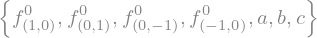

In [5]:
ac_cse.free_symbols

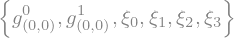

In [6]:
ac_cse.bound_symbols

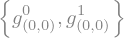

In [7]:
ac_cse.defined_symbols

Assignment collections can be splitted up, and merged together. For splitting, a list of symbols that occur on the left-hand-side in the main assignments has to be passed. The returned assignment collection only contains these main assignments together with all necessary subexpressions.

In [8]:
ac_f0 = ac_cse.new_filtered([g(0)])
ac_f1 = ac_cse.new_filtered([g(1)])
ac_f1

$$\xi_{0} \leftarrow_{} a^{2}$$
"$$\xi_{1} \leftarrow_{} {f}_{(0,-1)}^{0} \xi_{0}$$"
"$$\xi_{2} \leftarrow_{} - {f}_{(1,0)}^{0} c + {f}_{(0,1)}^{0} b - 2 {f}_{(-1,0)}^{0} c$$"
"$${g}_{(0,0)}^{1} \leftarrow_{} {f}_{(1,0)}^{0} \xi_{0} + {f}_{(0,1)}^{0} \xi_{0} + {f}_{(-1,0)}^{0} \xi_{0} + \xi_{1} + \xi_{2}$$"


Note here that $\xi_4$ is no longer part of the subexpressions, since it is not used in the main assignment of $f_C^1$.

If we merge both collections together, we end up with the original collection.

In [9]:
ac_f0.new_merged(ac_f1)

$$\xi_{0} \leftarrow_{} a^{2}$$
"$$\xi_{1} \leftarrow_{} {f}_{(0,-1)}^{0} \xi_{0}$$"
"$$\xi_{2} \leftarrow_{} - {f}_{(1,0)}^{0} c + {f}_{(0,1)}^{0} b - 2 {f}_{(-1,0)}^{0} c$$"
$$\xi_{3} \leftarrow_{} c^{2}$$
"$${g}_{(0,0)}^{0} \leftarrow_{} {f}_{(1,0)}^{0} \xi_{3} + {f}_{(0,1)}^{0} \xi_{3} + {f}_{(0,-1)}^{0} \xi_{3} + {f}_{(-1,0)}^{0} \xi_{3} - \xi_{1} + \xi_{2}$$"
"$${g}_{(0,0)}^{1} \leftarrow_{} {f}_{(1,0)}^{0} \xi_{0} + {f}_{(0,1)}^{0} \xi_{0} + {f}_{(-1,0)}^{0} \xi_{0} + \xi_{1} + \xi_{2}$$"


There is also a method that inserts all subexpressions into the main assignments. This is the inverse operation of common subexpression elimination.

In [10]:
assert sp.simplify(ac_f0.new_without_subexpressions().main_assignments[0].rhs - a2.rhs) == 0
ac_f0.new_without_subexpressions()

"$${g}_{(0,0)}^{0} \leftarrow_{} {f}_{(1,0)}^{0} c^{2} - {f}_{(1,0)}^{0} c + {f}_{(0,1)}^{0} b + {f}_{(0,1)}^{0} c^{2} - {f}_{(0,-1)}^{0} a^{2} + {f}_{(0,-1)}^{0} c^{2} + {f}_{(-1,0)}^{0} c^{2} - 2 {f}_{(-1,0)}^{0} c$$"


To evaluate an assignment collection, use the ``lambdify`` method. It is very similar to *sympy*s ``lambdify`` function.

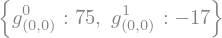

In [11]:
evalFct = ac_cse.lambdify([f[0,1], f[1,0]],  # new parameters of returned function
                          fixed_symbols={a:1, b:2, c:3, f[0,-1]: 4, f[-1,0]: 5}) # fix values of other symbols
evalFct(2,1)

lambdify is rather slow for evaluation. The intended way to evaluate an assignment collection is *pystencils* i.e. create a fast kernel, that applies the update at every site of a structured grid. The collection can be directly passed to the `create_kernel` function.

In [12]:
func = ps.create_kernel(ac_cse).compile()

## Simplification Strategies

In above examples, we already applied simplification rules to assignment collections. Simplification rules are functions that take, as a single argument, an assignment collection and return an modified/simplified copy of it. The ``SimplificationStrategy`` class holds a list of simplification rules and can apply all of them in the specified order. Additionally it provides useful printing and reporting functions. 

We start by creating a simplification strategy, consisting of the expand and CSE simplifications we have already applied above:

In [13]:
strategy = ps.simp.SimplificationStrategy()
strategy.add(ps.simp.apply_to_all_assignments(sp.expand))
strategy.add(ps.simp.sympy_cse)

This strategy can be applied to any assignment collection:

In [14]:
strategy(ac)

$$\xi_{0} \leftarrow_{} a^{2}$$
"$$\xi_{1} \leftarrow_{} {f}_{(0,-1)}^{0} \xi_{0}$$"
"$$\xi_{2} \leftarrow_{} - {f}_{(1,0)}^{0} c + {f}_{(0,1)}^{0} b - 2 {f}_{(-1,0)}^{0} c$$"
$$\xi_{3} \leftarrow_{} c^{2}$$
"$${g}_{(0,0)}^{1} \leftarrow_{} {f}_{(1,0)}^{0} \xi_{0} + {f}_{(0,1)}^{0} \xi_{0} + {f}_{(-1,0)}^{0} \xi_{0} + \xi_{1} + \xi_{2}$$"
"$${g}_{(0,0)}^{0} \leftarrow_{} {f}_{(1,0)}^{0} \xi_{3} + {f}_{(0,1)}^{0} \xi_{3} + {f}_{(0,-1)}^{0} \xi_{3} + {f}_{(-1,0)}^{0} \xi_{3} - \xi_{1} + \xi_{2}$$"


The strategy can also print the simplification results at each stage. 
The report contains information about the number of operations after each simplification as well as the runtime of each simplification routine.

In [15]:
strategy.create_simplification_report(ac)

Name,Runtime,Adds,Muls,Divs,Total
OriginalTerm,-,13,19,0,32
expand,0.03 ms,13,26,0,39
sympy_cse,0.52 ms,11,14,0,25


The strategy can also print the full collection after each simplification...

In [16]:
strategy.show_intermediate_results(ac)

"$${g}_{(0,0)}^{1} \leftarrow_{} {f}_{(1,0)}^{0} \left(a^{2} - c\right) + {f}_{(0,1)}^{0} \left(a^{2} + b\right) + {f}_{(0,-1)}^{0} a^{2} + {f}_{(-1,0)}^{0} \left(a^{2} - 2 c\right)$$"
"$${g}_{(0,0)}^{0} \leftarrow_{} {f}_{(1,0)}^{0} \left(c^{2} - c\right) + {f}_{(0,1)}^{0} \left(b + c^{2}\right) + {f}_{(0,-1)}^{0} \left(- a^{2} + c^{2}\right) + {f}_{(-1,0)}^{0} \left(c^{2} - 2 c\right)$$"
"$${g}_{(0,0)}^{1} \leftarrow_{} {f}_{(1,0)}^{0} a^{2} - {f}_{(1,0)}^{0} c + {f}_{(0,1)}^{0} a^{2} + {f}_{(0,1)}^{0} b + {f}_{(0,-1)}^{0} a^{2} + {f}_{(-1,0)}^{0} a^{2} - 2 {f}_{(-1,0)}^{0} c$$"
"$${g}_{(0,0)}^{0} \leftarrow_{} {f}_{(1,0)}^{0} c^{2} - {f}_{(1,0)}^{0} c + {f}_{(0,1)}^{0} b + {f}_{(0,1)}^{0} c^{2} - {f}_{(0,-1)}^{0} a^{2} + {f}_{(0,-1)}^{0} c^{2} + {f}_{(-1,0)}^{0} c^{2} - 2 {f}_{(-1,0)}^{0} c$$"
$$\xi_{0} \leftarrow_{} a^{2}$$
"$$\xi_{1} \leftarrow_{} {f}_{(0,-1)}^{0} \xi_{0}$$"
"$$\xi_{2} \leftarrow_{} - {f}_{(1,0)}^{0} c + {f}_{(0,1)}^{0} b - 2 {f}_{(-1,0)}^{0} c$$"
$$\xi_{3} \leftarrow_{} c^{2}$$
"$${g}_{(0,0)}^{1} \leftarrow_{} {f}_{(1,0)}^{0} \xi_{0} + {f}_{(0,1)}^{0} \xi_{0} + {f}_{(-1,0)}^{0} \xi_{0} + \xi_{1} + \xi_{2}$$"
"$${g}_{(0,0)}^{0} \leftarrow_{} {f}_{(1,0)}^{0} \xi_{3} + {f}_{(0,1)}^{0} \xi_{3} + {f}_{(0,-1)}^{0} \xi_{3} + {f}_{(-1,0)}^{0} \xi_{3} - \xi_{1} + \xi_{2}$$"


... or only specific assignments for better readability

In [18]:
strategy.show_intermediate_results(ac, symbols=[g(1)])

<pystencils.simp.simplificationstrategy.SimplificationStrategy.show_intermediate_results.<locals>.IntermediateResults at 0x1265a1b90>